### PART A

In [2]:
# Intro to BA - HW3 Python - Part a 

# Import necessary libraries
import pandas as pd
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, make_scorer
from sklearn.pipeline import Pipeline

# Load the dataset
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"
data = pd.read_csv(url, header=None)

# Rename columns
data.columns = ['ID', 'Diagnosis'] + [f"{feature}_{stat}" for feature in [
    'radius', 'texture', 'perimeter', 'area', 'smoothness',
    'compactness', 'concavity', 'concave_points', 'symmetry', 'fractal_dimension'
] for stat in ['mean', 'se', 'worst']]

In [3]:
# Preprocessing
# Set ID as index
data = data.set_index('ID')

# Convert the Diagnosis column to numeric (M -> 0, B -> 1)
data['Diagnosis'] = data['Diagnosis'].map({'M': 0, 'B': 1})

X = data.drop('Diagnosis', axis=1)
y = data['Diagnosis']

# Scale the features for k-NN
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Set up nested cross-validation
# Stratified KFOLD because we want each fold to each fold to have 
# the same proportion of classes (benign/malignant) as the original dataset 
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# F1-score is our metric for evaluation
f1 = make_scorer(f1_score)

In [4]:
# ------------
# MODEL 1: DECISION TREE
# ------------

dt = DecisionTreeClassifier(random_state=42)
dt_param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 10, 20],
    'criterion': ['gini', 'entropy']
}

# Use GridSearchCV to optimize the parameters
dt_grid = GridSearchCV(estimator=dt, param_grid=dt_param_grid, scoring=f1, cv=inner_cv)
dt_grid.fit(X, y)

# Print the best parameters and the best score
print("Best parameters found by GridSearchCV for Decision Tree:")
print(dt_grid.best_params_)

print(f"Best F1-score from GridSearchCV: {dt_grid.best_score_:.4f}")

# Perform nested cross-validation for dt
dt_nested_scores = cross_val_score(dt_grid, X, y, cv=outer_cv, scoring=f1)
print(f"Decision Tree Nested CV F1-Score: {dt_nested_scores.mean():.4f}")

Best parameters found by GridSearchCV for Decision Tree:
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2}
Best F1-score from GridSearchCV: 0.9509
Decision Tree Nested CV F1-Score: 0.9427


In [5]:
# ------------
# MODEL 2: k-NN
# ------------
knn = KNeighborsClassifier()
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1: Manhattan, 2: Euclidean
}

knn_grid = GridSearchCV(estimator=knn, param_grid=knn_param_grid, scoring=f1, cv=inner_cv)
knn_grid.fit(X_scaled, y)

# Print the best parameters and F1 score from GridSearchCV
print("\nBest parameters found by GridSearchCV for k-NN:")
print(knn_grid.best_params_)
print(f"Best F1-score from GridSearchCV (k-NN): {knn_grid.best_score_:.4f}")

# Perform nested cross-validation for k-NN
knn_nested_scores = cross_val_score(knn_grid, X_scaled, y, cv=outer_cv, scoring=f1)
print(f"k-NN Nested CV F1-Score: {knn_nested_scores.mean():.4f}")



Best parameters found by GridSearchCV for k-NN:
{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Best F1-score from GridSearchCV (k-NN): 0.9766
k-NN Nested CV F1-Score: 0.9740


In [6]:
# ------------ 
# MODEL 3: LOGISTIC REGRESSION
# ------------


logreg = LogisticRegression(random_state=42, max_iter=10000)
logreg_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100], # Regularization strength
    'penalty': ['l1', 'l2'], # L1 or L2 regularization type
    'solver': ['liblinear', 'saga'] # Solver for L1 and L2 (liblinear handles both, saga supports L1)
}

logreg_grid = GridSearchCV(estimator=logreg, param_grid=logreg_param_grid, scoring=f1, cv=inner_cv)
logreg_grid.fit(X, y)

# Print the best parameters and F1 score from GridSearchCV
print("\nBest parameters found by GridSearchCV for Logistic Regression:")
print(logreg_grid.best_params_)
print(f"Best F1-score from GridSearchCV (Logistic Regression): {logreg_grid.best_score_:.4f}")

# Perform nested cross-validation for Logistic Regression
logreg_nested_scores = cross_val_score(logreg_grid, X_scaled, y, cv=outer_cv, scoring=f1)
print(f"Logistic Regression Nested CV F1-Score: {logreg_nested_scores.mean():.4f}")


Best parameters found by GridSearchCV for Logistic Regression:
{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Best F1-score from GridSearchCV (Logistic Regression): 0.9708
Logistic Regression Nested CV F1-Score: 0.9809


### PART B

In [9]:
#### Importing Libraries 
##importing Libraries
import numpy as np   
import pandas as pd
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, make_scorer
from sklearn.pipeline import Pipeline
# Determines cross-validated training and test scores for different training set sizes
from sklearn.model_selection import learning_curve
import urllib.request
from io import StringIO
from sklearn import metrics
# Random permutation cross-validator
from sklearn.model_selection import ShuffleSplit #shuffling data 
# plots some lines in a plotting area, decorates the plot with labels, etc
import matplotlib.pyplot as plt

In [10]:
### Load Data From website 
##load data from website
link = "http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"
f = urllib.request.urlopen(link)
myfile = f.read().decode('utf-8')
# https://stackoverflow.com/questions/15138614/how-can-i-read-the-contents-of-an-url-with-python
# code copied from above url

# create some column names
# It would make sense to do so. Otherwise we must be very sensitive on numbers e.g. 3rd column is radius_mean
column_names = ['ID', 'Diagnosis'] + [
    f"{feature}_{stat}" for feature in [
        'radius', 'texture', 'perimeter', 'area', 'smoothness',
        'compactness', 'concavity', 'concave_points', 'symmetry', 'fractal_dimension'
    ] for stat in ['mean', 'se', 'worst']
]

data = pd.read_csv(StringIO(myfile), header=None, names=column_names)

data['Diagnosis'] = data['Diagnosis'].map({'M': 0, 'B': 1})

data.head()
X = data.iloc[:, 2:]  
y = data.iloc[:,1]

# Scale 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1,stratify=y)


In [11]:
###function for learning curve
from sklearn import linear_model
import numpy as np   
from sklearn.model_selection import learning_curve
# Determines cross-validated training and test scores for different training set sizes
from sklearn.model_selection import learning_curve
# Random permutation cross-validator
from sklearn.model_selection import ShuffleSplit #shuffling data 
# Logistic regression classifier class
from sklearn.linear_model import LogisticRegression # logistic 
# kNN classifier class
from sklearn import neighbors  # k-nn
# Each pyplot function makes some change to a figure: e.g., creates a figure, creates a plotting area in a figure,
# plots some lines in a plotting area, decorates the plot with labels, etc
import matplotlib.pyplot as plt

In [12]:
def plot_learning_curve(estimator,        
                        title,            
                        X, y,             
                        ylim=None,        
                        cv=None,          
                        n_jobs=1,         
                        train_sizes=np.linspace(.1, 1.0, 10)): # This is changed specifically for showing 10 different sizes 

    plt.figure()                    # display figure

    # Titles/labels for the plot are set
    plt.title(title)                
    if ylim is not None:            
        plt.ylim(*ylim)             
    plt.xlabel("Training examples") 
    plt.ylabel("Score")             
    
    # Learning curve calculation 
    
    train_sizes, train_scores, test_scores = learning_curve(estimator,  
                                                            X, y,     
                                                            cv=cv,     # cross-validation folds 
                                                            n_jobs=n_jobs, # will use 1 processor  
                                                            train_sizes=train_sizes) #
    
    train_scores_mean = np.mean(train_scores, axis=1) # compute the arithmetic mean along the specified axis.
    train_scores_std = np.std(train_scores, axis=1)   
    test_scores_mean = np.mean(test_scores, axis=1)   
    test_scores_std = np.std(test_scores, axis=1) 
    
    plt.grid()                                        # configure the grid lines in the plot
                                                      
    plt.fill_between(train_sizes,                            
                     train_scores_mean - train_scores_std,  
                     train_scores_mean + train_scores_std,   
                     alpha=0.1,                              
                     color="r")                             
    plt.fill_between(train_sizes,
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std,
                     alpha=0.1,
                     color="g")          
        
    plt.plot(train_sizes,                    
             train_scores_mean,                         
             'o-',                                         
             color="r",                                      # line of red color
             label="Training score")                         

    # Test data performance indicated with green
    plt.plot(train_sizes,
             test_scores_mean,
             'o-',
             color="g",                                      # line of green color
             label="Cross-validation score")

    plt.legend(loc="best")                      
                                            
    return plt       
    

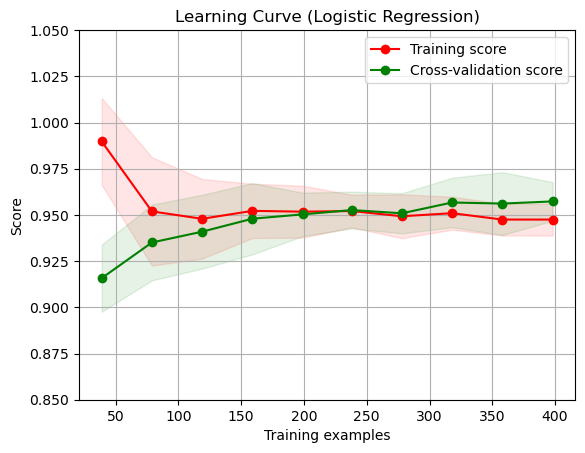

In [13]:
## Visualization of Learning Curve Logistic Regression 
###visualiztion of learning curve logistic regression
title = "Learning Curve (Logistic Regression)"

cv = ShuffleSplit(n_splits=10,          
                  test_size=0.3,        
                  random_state=42)      
estimator = LogisticRegression()        

# Plots the learning curve based on the previously defined function for the logistic regression estimator
plot_learning_curve(estimator,      
                    title,         
                    X, y,           
                    (0.85, 1.05), 
                    cv=cv,          
                    n_jobs=4)    

plt.show()                   


In [14]:
# Set up nested cross-validation
# Stratified KFOLD because we want each fold to each fold to have 
# the same proportion of classes (benign/malignant) as the original dataset 
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# F1-score is our metric for evaluation
f1 = make_scorer(f1_score)

# Create a pipeline that includes scaling and logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(random_state=42, max_iter=10000))
])

# Adjust your parameter grid to match the pipeline steps
logreg_param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10, 100],
    'logreg__penalty': ['l1', 'l2'],
    'logreg__solver': ['liblinear', 'saga']
}

# Use the pipeline in GridSearchCV
logreg_grid = GridSearchCV(estimator=pipeline, param_grid=logreg_param_grid, scoring=f1, cv=inner_cv)


gs_lr = logreg_grid.fit(X, y)
print("\n Parameter Tuning #4")
print("Non-nested CV F1 Score: ", gs_lr.best_score_)
print("Optimal Parameters: ", gs_lr.best_params_)
print("Optimal Estimator: ", gs_lr.best_estimator_)

nested_score_gs_lr = cross_val_score(gs_lr, X=X, y=y, cv=outer_cv, scoring=f1)
print("Nested CV F1 Score:", nested_score_gs_lr.mean(), " +/- ", nested_score_gs_lr.std())




 Parameter Tuning #4
Non-nested CV F1 Score:  0.9835010383341466
Optimal Parameters:  {'logreg__C': 0.1, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}
Optimal Estimator:  Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=0.1, max_iter=10000, random_state=42,
                                    solver='liblinear'))])
Nested CV F1 Score: 0.9821777693005057  +/-  0.01091241166559923


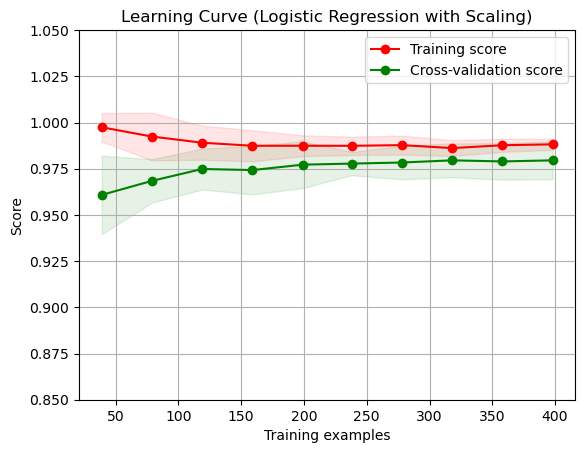

In [15]:
## Vilsualize with the optimal Parameter
# Learning curve plotting
title = "Learning Curve (Logistic Regression with Scaling)"
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=42)
estimator = pipeline

plot_learning_curve(estimator, title, X, y, (0.85, 1.05), cv=cv, n_jobs=4)
plt.show()

### PART C Accuracy

In [16]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, validation_curve, cross_val_score, train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, make_scorer, accuracy_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# Load the dataset
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"
data = pd.read_csv(url, header=None)

# Rename columns
data.columns = ['ID', 'Diagnosis'] + [f"{feature}_{stat}" for feature in [
    'radius', 'texture', 'perimeter', 'area', 'smoothness',
    'compactness', 'concavity', 'concave_points', 'symmetry', 'fractal_dimension'
] for stat in ['mean', 'se', 'worst']]

In [17]:
# Preprocessing
# Set ID as index
data = data.set_index('ID')

# Convert the Diagnosis column to numeric (M -> 0, B -> 1)
data['Diagnosis'] = data['Diagnosis'].map({'M': 0, 'B': 1})

X = data.drop('Diagnosis', axis=1)
y = data['Diagnosis']

# Scale the features for k-NN
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Set up nested cross-validation
# Stratified KFOLD because we want each fold to each fold to have 
# the same proportion of classes (benign/malignant) as the original dataset 
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# F1-score is our metric for evaluation
f1 = make_scorer(f1_score)

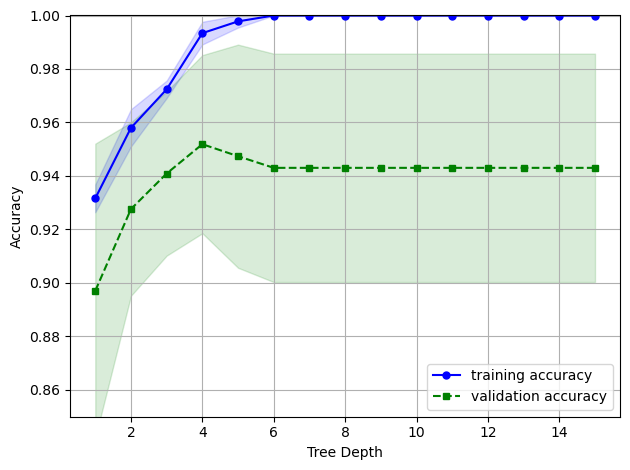

In [18]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=1)

np.random.seed(42)
param_range = np.arange(1, 16)

# Estimate Scores
train_scores, test_scores = validation_curve(
                DecisionTreeClassifier(random_state=42),
                X=X_train,                                    # data (features)
                y=y_train,                                    # target variable
                param_name="max_depth",                      
                param_range=param_range,                      # the values of the parameter that will be evaluated
                cv=10,                                        # 10-fold cross-validation
                scoring="accuracy",                           # evaluation metric
                n_jobs=4)  

train_mean = np.mean(train_scores, axis=1) # compute the arithmetic mean along the specified axis (train data)
train_std = np.std(train_scores, axis=1)   # compute the standard deviation along the specified axis (train data)
test_mean = np.mean(test_scores, axis=1)   # compute the arithmetic mean along the specified axis (test data)
test_std = np.std(test_scores, axis=1) # compute the standard deviation along the specified axis (test data)

# Visualization
# Plot train accuracy means of cross-validation for all the parameters C in param_range
plt.plot(param_range,                     
         train_mean,                      
         color='blue',                    
         marker='o',                      
         markersize=5,                    
         label='training accuracy')

# Fill the area around the line to indicate the size of standard deviations of performance for the training data
plt.fill_between(param_range,             
                 train_mean + train_std,  
                 train_mean - train_std,  
                 alpha=0.15,              
                 color='blue') 

# Plot test accuracy means of cross-validation for all the parameters C in param_range
plt.plot(param_range,
         test_mean,
         color='green',
         linestyle='--',
         marker='s',
         markersize=5,
         label='validation accuracy')

# Fill the area around the line to indicate the size of standard deviations of performance for the test data
plt.fill_between(param_range,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

# Grid and Axes Titles
plt.grid()
plt.legend(loc='lower right')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.ylim([0.85, 1.0]) # y limits in the plot
plt.tight_layout()
plt.show()

### PART D ROC

In [21]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, make_scorer
from sklearn.pipeline import Pipeline

# Load the dataset
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"
data = pd.read_csv(url, header=None)

# Rename columns
data.columns = ['ID', 'Diagnosis'] + [f"{feature}_{stat}" for feature in [
    'radius', 'texture', 'perimeter', 'area', 'smoothness',
    'compactness', 'concavity', 'concave_points', 'symmetry', 'fractal_dimension'
] for stat in ['mean', 'se', 'worst']]

In [22]:
# Preprocessing
# Set ID as index
data = data.set_index('ID')

# Convert the Diagnosis column to numeric (M -> 0, B -> 1)
data['Diagnosis'] = data['Diagnosis'].map({'M': 0, 'B': 1})

X = data.drop('Diagnosis', axis=1)
y = data['Diagnosis']

# Scale the features for k-NN
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Set up nested cross-validation
# Stratified KFOLD because we want each fold to each fold to have 
# the same proportion of classes (benign/malignant) as the original dataset 
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# F1-score is our metric for evaluation
f1 = make_scorer(f1_score)

In [23]:
# import 3 models
# MODEL 1: DECISION TREE

dt = DecisionTreeClassifier(random_state=42)
dt_param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 10, 20],
    'criterion': ['gini', 'entropy']
}

# Use GridSearchCV to optimize the parameters
dt_grid = GridSearchCV(estimator=dt, param_grid=dt_param_grid, scoring=f1, cv=inner_cv)
dt_grid.fit(X, y)
# Perform nested cross-validation for dt
dt_nested_scores = cross_val_score(dt_grid, X, y, cv=outer_cv, scoring=f1)

# MODEL 2: k-NN
knn = KNeighborsClassifier()
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1: Manhattan, 2: Euclidean
}

knn_grid = GridSearchCV(estimator=knn, param_grid=knn_param_grid, scoring=f1, cv=inner_cv)
knn_grid.fit(X_scaled, y)

# Perform nested cross-validation for k-NN
knn_nested_scores = cross_val_score(knn_grid, X_scaled, y, cv=outer_cv, scoring=f1)

# MODEL 3: LOGISTIC REGRESSION


logreg = LogisticRegression(random_state=42, max_iter=10000)
logreg_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100], # Regularization strength
    'penalty': ['l1', 'l2'], # L1 or L2 regularization type
    'solver': ['liblinear', 'saga'] # Solver for L1 and L2 (liblinear handles both, saga supports L1)
}

logreg_grid = GridSearchCV(estimator=logreg, param_grid=logreg_param_grid, scoring=f1, cv=inner_cv)
logreg_grid.fit(X, y)

# Perform nested cross-validation for Logistic Regression
logreg_nested_scores = cross_val_score(logreg_grid, X_scaled, y, cv=outer_cv, scoring=f1)

In [24]:
# ROC

############################### Import Libraries & Modules #################################

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [25]:
# Logistic Regression Classifier with optimal parameters
clf1 = LogisticRegression(penalty=logreg_grid.best_params_['penalty'],
                          C=logreg_grid.best_params_['C'],
                          solver=logreg_grid.best_params_['solver'],
                          random_state=42)

# Decision Tree Classifier with optimal parameters
clf2 = DecisionTreeClassifier(max_depth=dt_grid.best_params_['max_depth'],
                              min_samples_split=dt_grid.best_params_['min_samples_split'],
                              criterion=dt_grid.best_params_['criterion'],
                              random_state=42)

# k-NN Classifier with optimal parameters
clf3 = Pipeline([
    ('scaler', StandardScaler()),  # Scaling the features
    ('knn', KNeighborsClassifier(n_neighbors=knn_grid.best_params_['n_neighbors'],
                                 weights=knn_grid.best_params_['weights'],
                                 p=knn_grid.best_params_['p']))
])

# Label the classifiers
clf_labels = ['Logistic regression', 'Decision tree', 'k-NN']
all_clf = [clf1, clf2, clf3]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [26]:
#################################### Cross - Validation ####################################


print('10-fold cross validation:\n')
for clf, label in zip([clf1, clf2, clf3], clf_labels): #For all classifiers
    scores = cross_val_score(estimator=clf,  # estimate AUC based on cross validation
                             X=X,
                             y=y,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" # print peformance statistics based on cross-validation
          % (scores.mean(), scores.std(), label))

10-fold cross validation:



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


ROC AUC: 0.99 (+/- 0.01) [Logistic regression]
ROC AUC: 0.94 (+/- 0.03) [Decision tree]
ROC AUC: 0.99 (+/- 0.02) [k-NN]


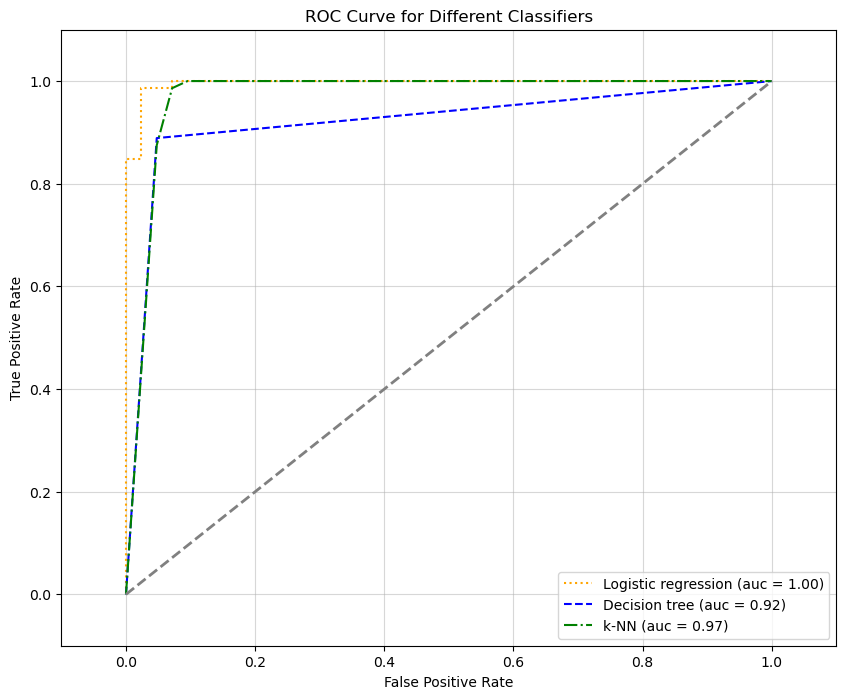

In [27]:
##################################### Visualization ######################################

# Plot initialization
plt.figure(figsize=(10, 8))
colors = ['orange', 'blue', 'green']  # Colors for classifiers
linestyles = [':', '--', '-.']        # Line styles for visualization

for clf, label, clr, ls in zip(all_clf, 
                               clf_labels, colors, linestyles):

     # Assuming the label of the positive class is 1 and data is normalized
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1] # make predictions based on the classifiers

    # Builf ROC curve
    fpr, tpr, thresholds = roc_curve(y_true = y_test, 
                                     y_score = y_pred)

    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, 
             color=clr, 
             linestyle=ls, 
             label='%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right') 
plt.plot([0, 1], [0, 1],
         linestyle='--', 
         color='gray',  
         linewidth=2)

# Final touches on plot
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Different Classifiers')


# Show plot
plt.show()